In [1]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation
plt.style.use('dark_background')

tau = 2 * np.pi

In [2]:
import sys
sys.path.append('../')

In [3]:
from modules.data_utils import parse_svg

points = parse_svg('../data/fourier.svg')
# Make it centered around the origin (optional).
points -= points.mean()
# Shift the center by a small amount.
shift = 0.1*np.ptp(points.real)
points += shift * np.exp(1j*tau*np.random.rand())

paths:   0%|          | 0/1 [00:00<?, ?it/s]

time:   0%|          | 0/1001 [00:00<?, ?it/s]

## Using numpy's Fast Fourier Transform

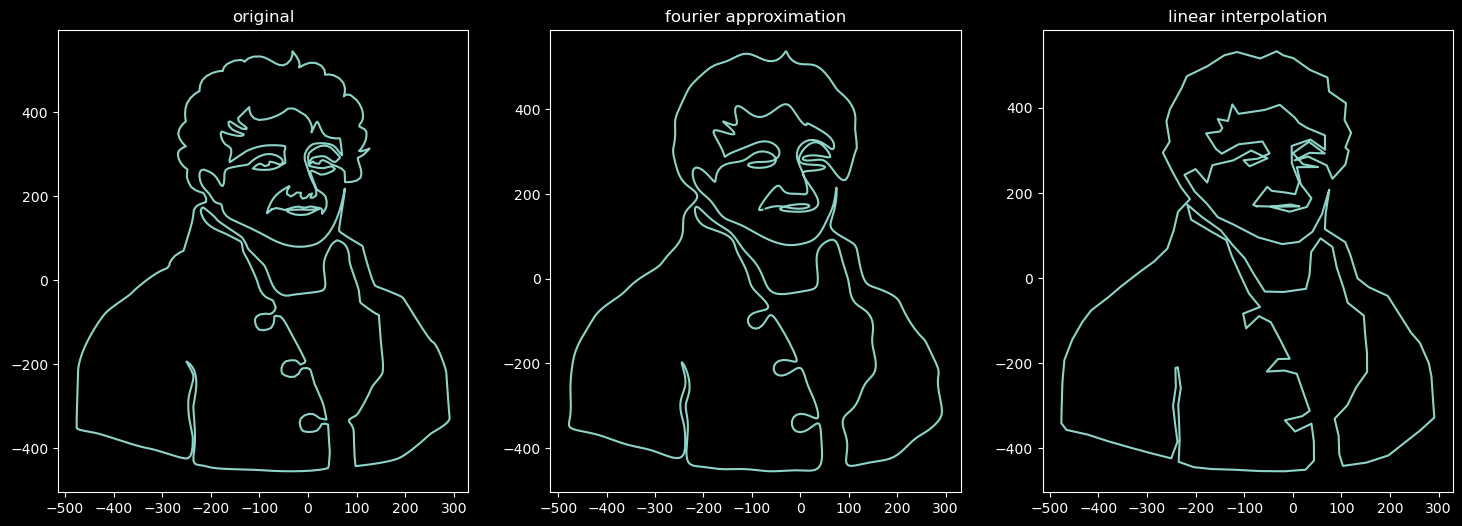

In [4]:
num_coeffs = None  # Would be taken as len(points) if None is passed.
coeffs = np.fft.fft(points, n=num_coeffs)
num_coeffs = len(coeffs)

def get_alternating_sequence(n):
  indices = np.arange(n)           #  0,  1,  2,  3,  4, ...
  signs = 2*(indices % 2) - 1      # -1,  1, -1,  1, -1, ...
  magnitudes = (indices + 1) // 2  #  0,  1,  1,  2,  2, ...
  return signs * magnitudes        #  0,  1, -1,  2, -2, ...

def inv_FFT(coeffs: np.ndarray, num_coeffs: int) -> np.ndarray:
  '''Zero out the lesser contributing coeffs so that curve length remains the same,
  and we get a smooth approximation.'''
  sequence = get_alternating_sequence(num_coeffs)
  coeffs_partial = np.zeros_like(coeffs)
  coeffs_partial[sequence] = coeffs[sequence]
  points_appr = np.fft.ifft(coeffs_partial)
  return points_appr


n_pts_approx = 201
fig, axs = plt.subplots(1,3, figsize=(18,6))
axs[0].plot(points.real, points.imag)
axs[0].set_title('original')
points_appr = inv_FFT(coeffs, n_pts_approx)
axs[1].plot(points_appr.real, points_appr.imag)
axs[1].set_title('fourier approximation')
points_appr = np.interp(np.linspace(0,len(points), n_pts_approx),
                        range(len(points)), points)
axs[2].plot(points_appr.real, points_appr.imag)
axs[2].set_title('linear interpolation')
plt.show()

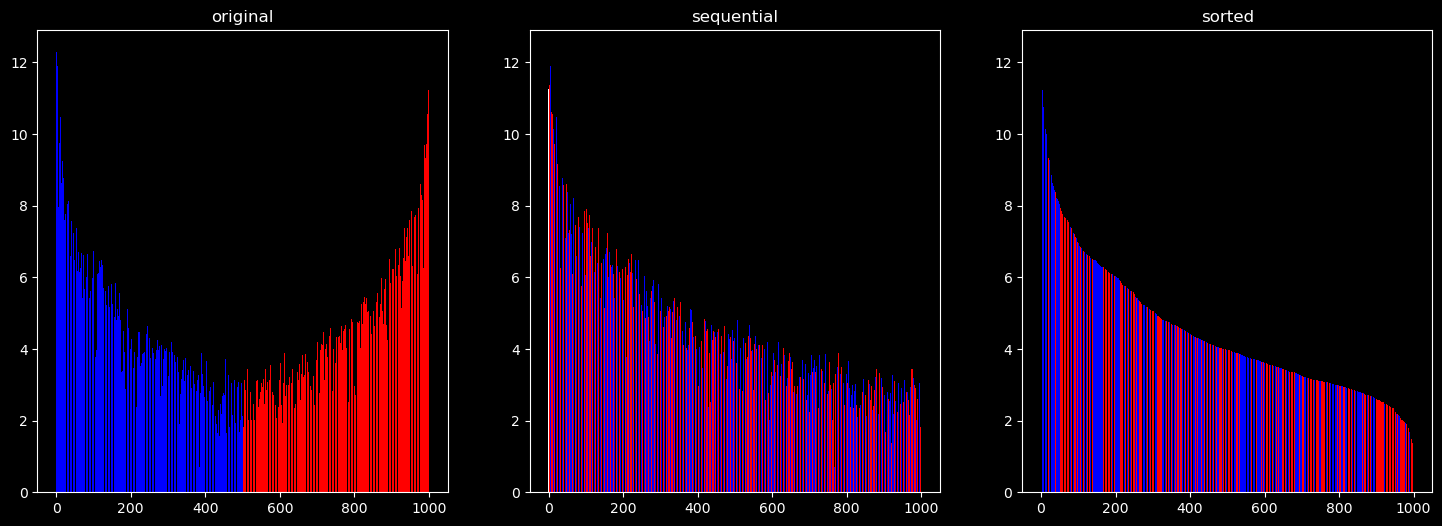

In [8]:
ignore_zeroth = False
freqs = coeffs
if ignore_zeroth:
  freqs = freqs[1:]

fig, axs = plt.subplots(1,3, figsize=(18,6))

colors = ['w'] + ['b']*(len(freqs)//2) + ['r']*(len(freqs)//2)
axs[0].bar(range(len(freqs)), np.log(1+abs(freqs)), color=colors)
axs[0].title.set_text('original')

sorted_indices = get_alternating_sequence(len(freqs))
freqs = freqs[sorted_indices]
colors = [colors[i] for i in sorted_indices]
axs[1].bar(range(len(freqs)), np.log(1+abs(freqs)), color=colors)
axs[1].title.set_text('sequential')

sorted_indices = np.argsort(abs(freqs))[::-1]
freqs = freqs[sorted_indices]
colors = [colors[i] for i in sorted_indices]
axs[2].bar(range(len(freqs)), np.log(1+abs(freqs)), color=colors)
axs[2].title.set_text('sorted')

plt.show()

if ignore_zeroth:
  sorted_indices += 1
  sorted_indices = np.insert(sorted_indices, 0, 0)

In [9]:
def generate_points_approximations(coeffs, num_coeffs, sequence=None):
  points_apprs = []

  if sequence is None:
    sequence = get_alternating_sequence(num_coeffs)
  else:
    assert len(sequence) == num_coeffs
  coeffs_partial = np.zeros_like(coeffs)
  
  for n in tqdm(range(1,1+num_coeffs)):
    coeffs_partial[sequence[:n]] = coeffs[sequence[:n]]
    points_apprs.append(np.fft.ifft(coeffs_partial))
  
  points_apprs = np.array(points_apprs)
  # Add the constant line from the origin (optional).
  points_apprs = np.insert(points_apprs, 0, 0, axis=0)
  return points_apprs

points_apprs = generate_points_approximations(coeffs, 201, None)

  0%|          | 0/201 [00:00<?, ?it/s]

### Evolution animation

In [6]:
from celluloid import Camera

In [7]:
fig, ax = plt.subplots()
camera = Camera(fig)
plt.axis('off')

for num_coeffs, points_appr in enumerate(tqdm(points_apprs[1:],
                                              desc='generating evolution animation'), 1):
  plt.plot(points_appr.real, points_appr.imag, c='y')
  plt.text(0.4, 1.05, f'num coeffs: {num_coeffs}', transform = ax.transAxes)
  camera.snap()
plt.close(fig)  
  
anim = camera.animate()
FFwriter = animation.FFMpegWriter(fps=1)
anim.save(f"../animations/evolution.mp4", writer=FFwriter, dpi=300)

generating evolution animation:   0%|          | 0/201 [00:00<?, ?it/s]

### Widget

In [10]:
from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.widgets import Slider, CheckButtons, RadioButtons
from matplotlib.backend_bases import MouseButton

In [11]:
def compute_orientations(centers_t0, centers_t1):
  dt0, dt1 = np.diff(centers_t0), np.diff(centers_t1)
  arg1, arg2 = np.angle(dt0),  np.angle(dt1)
  arg_diff = arg2 - arg1
  arg_diff[abs(arg_diff) < 1e-15] = 0
  return np.sign(arg_diff)

def color_picker(orientation):
  if orientation == 0: return 'w'
  elif orientation == 1: return 'b'
  elif orientation == -1: return 'r'

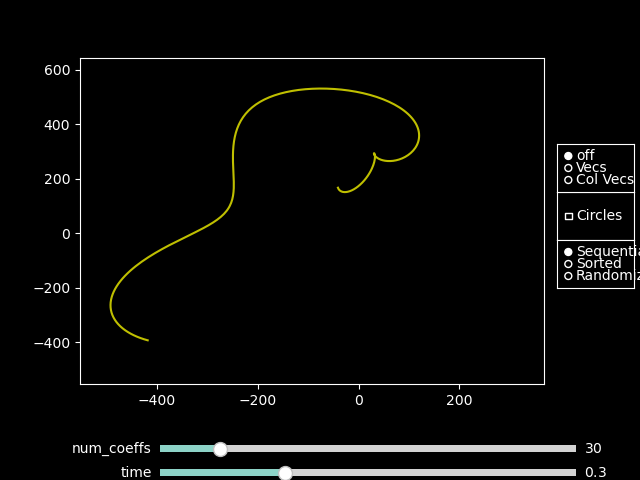

In [12]:
%matplotlib ipympl

fig, axs = plt.subplots()
plt.subplots_adjust(bottom=0.2, right=0.85)
# plt.plot(points.real, points.imag, alpha=0.3)
x_pad, y_pad = 0.1*np.ptp(points.real), 0.1*np.ptp(points.imag)
axs.set_xlim(points.real.min() - x_pad, points.real.max() + x_pad)
axs.set_ylim(points.imag.min() - y_pad, points.imag.max() + y_pad)

time = .3
num_coeffs = 30
max_coeffs, max_points = points_apprs.shape
max_coeffs -= 1

curve, = plt.plot([], c='y')
coll_lines = LineCollection([])
axs.add_collection(coll_lines)
coll_circles = PatchCollection([], alpha=0.3, color='white', facecolor='None')
axs.add_collection(coll_circles)

origin = plt.scatter(0, 0, c='w', visible=False)
orientations = compute_orientations(points_apprs[:,0], points_apprs[:,1])
colors = list(map(color_picker, orientations))

# Define the function to update the plot based on interaction.
def update_plot_data():
  # Draw the curve.
  time_points = int(time*(max_points-1))
  curve_appr = points_apprs[num_coeffs, :time_points+1]
  curve.set_data(curve_appr.real, curve_appr.imag)
  vectors_appr = None

  # Draw the rotating vectors.
  if not radio_buttons.value_selected == 'off':
    origin.set_visible(True)
    vectors_appr = points_apprs[:num_coeffs+1, time_points]
    lines = np.column_stack((vectors_appr[:-1], vectors_appr[1:]))
    segments = np.dstack([lines.real, lines.imag])
    coll_lines.set_segments(segments)
    if radio_buttons.value_selected == 'Col Vecs':
      coll_lines.set_colors(colors[:num_coeffs+1])
    elif radio_buttons.value_selected == 'Vecs':
      coll_lines.set_colors('w')
  else:
    origin.set_visible(False)
    coll_lines.set_segments([])

  # Draw the circles.
  if check_buttons.get_status()[0]:
    if vectors_appr is None:
      vectors_appr = points_apprs[:num_coeffs+1, time_points]
    radii = abs(np.diff(vectors_appr))
    circles = [plt.Circle((center.real, center.imag), radius)
               for center, radius in zip(vectors_appr, radii)]
    coll_circles.set_paths(circles)
  else:
    coll_circles.set_paths([])


# Define the sliders.
ax_CoeffsSlider = plt.axes([0.25, 0.05, 0.65, 0.03])
Coeffs_slider = Slider(ax_CoeffsSlider, 'num_coeffs',
                       1, max_coeffs, valinit=num_coeffs, valstep=1)
def update_coeffs(num_coeffs_updated):
  global num_coeffs
  num_coeffs = num_coeffs_updated
  update_plot_data()
Coeffs_slider.on_changed(update_coeffs)

ax_TimeSlider = plt.axes([0.25, 0.0, 0.65, 0.03])
Time_slider = Slider(ax_TimeSlider, 'time',
                     0, 1, valinit=time, valstep=1e-4)
def update_time(time_updated):
  global time
  time = time_updated
  update_plot_data()
Time_slider.on_changed(update_time)


# Define the check buttons and radio buttons.
ax_CheckButtons = plt.axes([0.87, 0.5, 0.12, 0.1])
check_buttons = CheckButtons(ax_CheckButtons, ['Circles'],
                             frame_props={'edgecolor': 'w'},
                             check_props={'facecolor': 'w'})
check_buttons.on_clicked(lambda label: update_plot_data())
ax_RadioButtons = plt.axes([0.87, 0.6, 0.12, 0.1])
radio_buttons = RadioButtons(ax_RadioButtons, ['off', 'Vecs', 'Col Vecs'],
                             radio_props={'edgecolor': 'w', 'facecolor': 'w'})
radio_buttons.on_clicked(lambda label: update_plot_data())
ax_RadioButtons = plt.axes([0.87, 0.4, 0.12, 0.1])
def on_click(label):
  global points_apprs, orientations, colors
  sequence = get_alternating_sequence(max_coeffs)
  new_coeffs = coeffs[sequence]
  if label == 'Sequential':
    new_sequence = sequence
  elif label == 'Sorted':
    new_sequence = sequence[np.argsort(abs(new_coeffs))[::-1]]
  elif label == 'Randomized':
    new_sequence = np.random.permutation(sequence)
  points_apprs = generate_points_approximations(coeffs, max_coeffs, new_sequence)
  orientations = compute_orientations(points_apprs[:,0], points_apprs[:,1])
  colors = list(map(color_picker, orientations))
  update_plot_data()
sort_buttons = RadioButtons(ax_RadioButtons, ['Sequential', 'Sorted', 'Randomized'],
                             radio_props={'edgecolor': 'w', 'facecolor': 'w'})
sort_buttons.on_clicked(on_click)


# Add key press.
def on_press(event):
  if event.key == 'right' and num_coeffs < max_coeffs:
    Coeffs_slider.set_val(num_coeffs + 1)
  elif event.key == 'left' and num_coeffs > 1:
    Coeffs_slider.set_val(num_coeffs - 1)
fig.canvas.mpl_connect('key_press_event', on_press)

# Add scroll event.
def on_scroll(event):
  global time
  dt = 1e-2
  time -= dt * event.step
  time = np.clip(time, 0, 1)
  Time_slider.set_val(time)
fig.canvas.mpl_connect('scroll_event', on_scroll)

# Initial plot with the params defined at the top.
update_plot_data()
plt.show()

In [13]:
plt.close()